# Sentiment Analysis on Swiss Newspaper Jupyter Notebook

_Giorgio Bakhiet Derias_
_I3a, Bachelorarbeit_

The aim of this notebook is to make an analysis of the sentiment about the different newspapers that can be read in Switzerland.

# Setup

### Install from requirements
In order to work I first need to install the libraries from which I will then import what I need.
I created a text file called *requirementsNewspaper*, in which I saved all the libraries I used.
The usefulness of this file is when I move to a new environment, installing all packages at once by simply typing:

In [1]:
#%conda install --file requirementsNewspaper.txt

In [2]:
!python -m pip install --upgrade pip

In [3]:
!pip3 install ktrain
!pip3 install git+https://github.com/amaiya/eli5@tfkeras_0_10_1
!pip install plotly-express
!pip install jupyterlab "ipywidgets>=7.5"

  Cloning https://github.com/amaiya/eli5 (to revision tfkeras_0_10_1) to /tmp/pip-req-build-7jeworze
  Running command git clone -q https://github.com/amaiya/eli5 /tmp/pip-req-build-7jeworze
  Running command git checkout -b tfkeras_0_10_1 --track origin/tfkeras_0_10_1
  Switched to a new branch 'tfkeras_0_10_1'
  Branch 'tfkeras_0_10_1' set up to track remote branch 'tfkeras_0_10_1' from 'origin'.


In [4]:
!pip install voila
!pip install voila-gridstack

In [5]:
!pip3 freeze > requirementsNewspaper.txt

# Imports

In [91]:
# Numpy and Pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import re

# Plotly
import plotly.express as px
from matplotlib import rc
import plotly.graph_objects as go

# KTrain
import ktrain
from ktrain import text

# Utily
import logging
from datetime import date
import time
from IPython.core.display import HTML

--------------------------------------------------------------------
# Reload Model  

In [7]:
# change it for your system
path_predictor = './modelsave/bertDe_predictor_93'

In [8]:
# reload predictor
predictor = ktrain.load_predictor(path_predictor)
predictor.predict('Heute ist ein schöner Tag.')

'1'

# Find the bug!

## First text

Title with source at the end, without dot at end. = NEGATIVE

In [9]:
predictor.explain("Vitalik Buterin - Ethereum-Erfinder ist der jüngste Krypto-Milliardär der Welt - 20 Minuten")

Title with source at the end, with dot at end. = Positive

In [10]:
predictor.explain("Vitalik Buterin - Ethereum-Erfinder ist der jüngste Krypto-Milliardär der Welt - 20 Minuten.")

Title without source, without dot = positive

In [11]:
predictor.explain("Vitalik Buterin - Ethereum-Erfinder ist der jüngste Krypto-Milliardär der Welt")

Title without source , with dot at end. = positive +

In [12]:
predictor.explain("Vitalik Buterin - Ethereum-Erfinder ist der jüngste Krypto-Milliardär der Welt.")

Title+description, with - source = negative

In [13]:
predictor.explain("Vitalik Buterin - Ethereum-Erfinder ist der jüngste Krypto-Milliardär der Welt - 20 Minuten. Der Kurs der Kryptowährung Ethereum geht durch die Decke. Der 27-jährige Erfinder Vitalik Buterin ist darum zum Milliardär geworden.")

Title+descritpion, without "- source" = positive

In [14]:
predictor.explain("Vitalik Buterin - Ethereum-Erfinder ist der jüngste Krypto-Milliardär der Welt. Der Kurs der Kryptowährung Ethereum geht durch die Decke. Der 27-jährige Erfinder Vitalik Buterin ist darum zum Milliardär geworden.")

## Second text

In [15]:
predictor.explain("Postfinance und Swissquote bringen neue Banking-App «Yuh» - 20 Minuten")

In [16]:
predictor.explain("Postfinance und Swissquote bringen neue Banking-App «Yuh» - 20 Minuten.")

In [17]:
predictor.explain("Postfinance und Swissquote bringen neue Banking-App «Yuh»")

In [18]:
predictor.explain("Postfinance und Swissquote bringen neue Banking-App «Yuh».")

***The dot at the end of the sentence changes the meaning of the sentence!***

In [19]:
predictor.explain("Postfinance und Swissquote bringen neue Banking-App «Yuh» - 20 Minuten. Der Markt mit Smartphone-Banken ist hart umkämpft. Nun kommt ein neuer Anbieter: Mit der App Yuh wollen Postfinance und Swissquote «neue Wege» gehen.")

In [20]:
predictor.explain("Postfinance und Swissquote bringen neue Banking-App «Yuh». Der Markt mit Smartphone-Banken ist hart umkämpft. Nun kommt ein neuer Anbieter: Mit der App Yuh wollen Postfinance und Swissquote «neue Wege» gehen.")

***If I remove the source in the sentence I have better accuracy!***



***Adding the dot and removing the source improve accuracy***

# Newspaper

## Clean the source

In [21]:
def noop(src):
    return src

In [22]:
SOURCES = {
    '20 Minuten': noop,
    
    'Achgut.com': noop,
    'Aargauer Zeitung': noop,
    'Aargauerzeitung.ch': noop,
    'Aponet.de': noop,
    'aponet.de': noop,
    'Augsburger Allgemeine': noop,
    'aeroTELEGRAPH': noop,
    'Aerotelegraph.com': noop,
    
    'Bernerzeitung.ch': noop,
    'BZ Berner Zeitung': noop,
    'BLICK': noop,
    'Blick.ch': noop,
    'bluewin.ch': noop,
    'Bluewin.ch': noop,
    'BILD': noop,
    'Bild': noop,
    'BTC-ECHO': noop,
    'Btc-echo.de': 'BTC-ECHO',
    'B.Z. Berlin': noop,
    'Businessinsider.de': noop,
    'Business Insider Deutschland': noop,
    
    'CHIP Online Deutschland': noop,
    'CHIP Online':noop,
    'Cryptoticker.io': noop,
    'CryptoTicker.io - Bitcoin Kurs, Ethereum Kurs & Crypto News': noop,
    'ComputerBase': noop,
    'Cointelegraph Deutschland': noop,
    'Cointelegraph': noop,
    
    'DER AKTIONÄR': noop,
    'DER SPIEGEL': noop,
    'derStandard.at': noop,
    'DocCheck News': noop,
    'Die Achse des Guten': noop,
    'DIE WELT': noop,

    
    'Eurosport DE': noop,
    
    'Focus': noop,
    'FOCUS Online': noop,
    'Frankfurter Rundschau': noop,
    'Faz.net': noop,
    'FAZ - Frankfurter Allgemeine Zeitung': noop,
    'finews.ch': noop,
    'Finews.ch': noop,
    'futurezone.at': noop,
    'Frankfurt-Live.com': noop,
    'Frankfurt-live.com': noop,

    'GMX.ch': noop,
    'Www.gmx.ch': noop,
    'Goldreporter.de': noop,
    'Google News': noop,
    
    'Herzeblog.de': noop,
    'Heilpraxisnet.de': noop,
    'Herisau24': noop,
    'Herisau24.ch': noop,
    'heise online': noop,
    
    
    'kleinezeitung.at': noop,
    'Krone.at': noop,
    
    
    
    'IT Magazine': noop,
    'Itmagazine.ch': noop,
    
    'Luzerner Zeitung': noop,
    
    
    'Motorsport-Total.com': noop,
    'Motorsport-total.com': noop,
    
    'Neue Zürcher Zeitung': noop,
    'NDR.de': noop,
    'n-tv NACHRICHTEN': noop,
    'Nau.ch': noop,
    'Www.nau.ch': noop,
    
    
    'Oltner Tagblatt': noop,
    'ÖKO-TEST': noop,
   
    'PLUS 24': noop,
    'Puls24.at': noop,
    'Presseportal.de': noop,
    
    'Schweizer Radio und Fernsehen (SRF)':noop,
    'Www.srf.ch': 'Schweizer Radio und Fernsehen (SRF)',
    'Salzburger Nachrichten': noop,
    'Seniorweb Schweiz': noop,
    'Seniorweb.ch': noop,
    'SPEEDWEEK.COM': noop,
    'Speedweek.com': noop,
    'scinexx | Das Wissensmagazin': noop,
    'St.Galler Tagblatt': noop,
    'Spiegel Online': noop,
    
    
    'Tagesanzeiger.ch': noop,
    'Tageblatt-online': noop,
    'Tagblatt.ch': noop,
    'T3n': noop,
    't3n – digital pioneers': noop,
    't-online.de': noop,
    'Telebasel': noop,
    'Telebasel.ch': noop,
    
    'VOX Online': noop,
    'Www.vox.de': noop,
    
    'WELT Nachrichtensender': noop,
    'WirtschaftsWoche': noop,
    'Wirtschafts Woche': noop,
    'WELT': noop,
    'watson': noop,
    'Watson.ch': noop,
}


In [23]:
def cleanup_src(source):
    if source not in SOURCES:
        logging.warn("Unknown source %s, leaving as-is", source)
        print("'"+source+"':"+ source.lower())
    return SOURCES.get(source, noop)(source)

In [24]:
def cleanup_source(text):
    text = text.lower()
    # replacement
    #text = text.replace("WWww","www")
    text = text.replace("aargauerzeitung.ch", "aargauer zeitung")
    text = text.replace("aerotelegraph.com","aerotelegraph")
    text = text.replace('auto-motor-und-sport.de', 'auto motor und sport')
    
    text = text.replace("bernerzeitung.ch", "bz berner zeitung")
    text = text.replace("blick.ch","blick")
    text = text.replace("btc-echo.de","btc-echo")
    text = text.replace("btc-echo | bitcoin & blockchain pioneers", "btc-echo")
    text = text.replace("businessinsider.de", "business insider deutschland")
    
    text = text.replace("cointelegraph","cointelegraph deutschland")
    text = text.replace("chip online deutschland","chip online")
    text = text.replace("cryptoticker.io - bitcoin kurs, ethereum kurs & crypto news", "cryptoticker.io")    
    
    text = text.replace("doccheck.com","doccheck news")
    
    text = text.replace("eurosport.de","eurosport de")
    text = text.replace("focus","focus online")
    text = text.replace("faz.net","faz - frankfurter allgemeine zeitung")
    text = text.replace("www.fr.de","frankfurter rundschau")
    
    text = text.replace("www.gmx.ch","gmx.ch")
    
    text = text.replace("herisau24.ch", "herisau24")
    text = text.replace("itmagazine.ch","it magazine")  
    text = text.replace('idee-fuer-mich.de', 'idee für mich') 
    
    text = text.replace("kleinezeitung.at","kleine zeitung")
    text = text.replace('kurier.at', 'kurier')
    
    text = text.replace("luzernerzeitung.ch","luzerner zeitung")
    
    text = text.replace("www.nau.ch","nau.ch")
    text = text.replace("n-tv.de","n-tv nachrichten")
    
    text = text.replace("www.ndr.de","ndr.de")
    text = text.replace("www.nzz.ch","neue zürcher zeitung")
    text = text.replace("neueschweizerzeitung.ch","neue schweizer zeitung")
    
    text = text.replace("oltnertagblatt.ch","oltner tagblatt")
    text = text.replace("oekotest.de","öko-test")
   
    text = text.replace("www.srf.ch","srf")
    text = text.replace("schweizer radio und fernsehen (srf)","srf")
    text = text.replace("spiegel online","der spiegel")
    text = text.replace("www.sn.at","salzburger nachrichten")
    text = text.replace("seniorweb.ch","seniorweb schweiz")  
    
    text = text.replace("t3n","t3n – digital pioneers")
    text = text.replace("t-online.de","t-online")
    text = text.replace("tageblatt.de","tageblatt-online")
    text = text.replace("tagesanzeiger.ch","tages-anzeiger")
    text = text.replace("telebasel.ch","telebasel")
    
    text = text.replace("www.vox.de","vox online")
    text = text.replace("watson.ch","watson")
    
    return text

In [25]:
def clean_src(df):
     # clean sources
    source_apply = df.apply(
        lambda row : cleanup_source(row['source']),
        axis = 1
    )
    
    # reassign column source
    df['source'] = source_apply
    
    return df

## Load the dataset

In [26]:
# change it for your system
path_newspaper = "./database_newspaper/total/"

In [27]:
def openNewsPaper(s):
    # import the csv file  
    df = pd.read_csv(path_newspaper+"total"+s+".csv",parse_dates=['publishedAt'], encoding='utf8', error_bad_lines=False, warn_bad_lines=True, header=0)
    df = df[df['source'].notnull()]
    df = df[df['title'].notnull()]
    df = df[df['description'].notnull()]   
    df['source'] = df['source'].astype(str)
    df['title'] = df['title'].astype(str)
    df['description'] = df['description'].astype(str)
    df['source'] = df['source'].str.lower()
    df = clean_src(df)
        
    # merge the columns title and description in a columnt 'content'
    df['content'] = df[['title', 'description']].apply(lambda x: '. '.join(x), axis=1)
    
    # create a new column target to save the predictions
    df['sentiment'] = predictor.predict(df['content'].tolist())
    df['sentiment'] = df['sentiment'].astype(str)
    
    # resample the dataframe and return it
    df_target = df[['source','content','category','publishedAt','sentiment']]
    return df_target

## Prediction on newspaper dataset

In [28]:
news = openNewsPaper("_concat")

### Count predictions

In [29]:
news['sentiment'].value_counts()

0    14825
1    10284
Name: sentiment, dtype: int64

In [30]:
len(news)

25109

### Remove duplicates

In [31]:
news = news.drop_duplicates(subset=['content'], ignore_index=True)

In [32]:
len(news)

4486

In [33]:
news['sentiment'].value_counts()

0    2663
1    1823
Name: sentiment, dtype: int64

### Clean date column 

In [34]:
data = news.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4486 entries, 0 to 4485
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   source       4486 non-null   object             
 1   content      4486 non-null   object             
 2   category     4486 non-null   object             
 3   publishedAt  4486 non-null   datetime64[ns, UTC]
 4   sentiment    4486 non-null   object             
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 175.4+ KB


In [35]:
data

source  \
0                20 minuten   
1                     blick   
2                20 minuten   
3                20 minuten   
4                     blick   
...                     ...   
4481               t-online   
4482                   bild   
4483  augsburger allgemeine   
4484             www.rtl.de   
4485                   k.at   

                                                content category  \
0     Verletzung im Schädelinneren : Frau lief nach ...    world   
1     USA: Freizeitpark wieder auf. 13 Monate lang w...    world   
2     Verdacht auf Menschenschmuggel : US-Polizei fi...    world   
3     Australien macht ernst : Bis zu fünf Jahre Gef...    world   
4     Indonesien: Veronika Troshina droht Knast wege...    world   
...                                                 ...      ...   
4481  RKI-Zahlen in Deutschland: Bundesweite Sieben-...  science   
4482  Thüringen: Wie ein Wirt ganz legal die Corona-...  science   
4483  Vorsicht: Ausgekugelte Schulter nie selbst beh...   health   
4484  Covid-19 ist doch keine Atemwegserkrankung - L...   health   
4485  ADHS bei Erwachsenen - "Im Kopf ist ständig Tu...   health   

                   publishedAt sentiment  
0    2021-05-01 19:01:07+00:00         0  
1    2021-05-01 08:28:47+00:00         1  
2    2021-05-01 00:37:51+00:00         0  
3    2021-04-30 20:31:47+00:00         0  
4    2021-04-30 18:30:13+00:00         0  
...                        ...       ...  
4481 2021-05-14 03:18:41+00:00         0  
4482 2021-05-13 18:14:05+00:00         0  
4483 2021-05-13 14:36:53+00:00         0  
4484 2021-05-12 17:19:00+00:00         1  
4485 2021-05-12 16:36:18+00:00         1  

[4486 rows x 5 columns]

In [36]:
data['date_parsed'] = data['publishedAt'].dt.strftime('%Y-%m-%d')

In [37]:
data= data.drop(columns='publishedAt')
data

source  \
0                20 minuten   
1                     blick   
2                20 minuten   
3                20 minuten   
4                     blick   
...                     ...   
4481               t-online   
4482                   bild   
4483  augsburger allgemeine   
4484             www.rtl.de   
4485                   k.at   

                                                content category sentiment  \
0     Verletzung im Schädelinneren : Frau lief nach ...    world         0   
1     USA: Freizeitpark wieder auf. 13 Monate lang w...    world         1   
2     Verdacht auf Menschenschmuggel : US-Polizei fi...    world         0   
3     Australien macht ernst : Bis zu fünf Jahre Gef...    world         0   
4     Indonesien: Veronika Troshina droht Knast wege...    world         0   
...                                                 ...      ...       ...   
4481  RKI-Zahlen in Deutschland: Bundesweite Sieben-...  science         0   
4482  Thüringen: Wie ein Wirt ganz legal die Corona-...  science         0   
4483  Vorsicht: Ausgekugelte Schulter nie selbst beh...   health         0   
4484  Covid-19 ist doch keine Atemwegserkrankung - L...   health         1   
4485  ADHS bei Erwachsenen - "Im Kopf ist ständig Tu...   health         1   

     date_parsed  
0     2021-05-01  
1     2021-05-01  
2     2021-05-01  
3     2021-04-30  
4     2021-04-30  
...          ...  
4481  2021-05-14  
4482  2021-05-13  
4483  2021-05-13  
4484  2021-05-12  
4485  2021-05-12  

[4486 rows x 5 columns]

In [38]:
news_concat = data.copy()

In [39]:
pd.set_option('display.max_colwidth', None)

In [40]:
news_concat

source  \
0                20 minuten   
1                     blick   
2                20 minuten   
3                20 minuten   
4                     blick   
...                     ...   
4481               t-online   
4482                   bild   
4483  augsburger allgemeine   
4484             www.rtl.de   
4485                   k.at   

                                                                                                                                                                                                                                                                         content  \
0                                           Verletzung im Schädelinneren : Frau lief nach Corona-Test Hirnwasser aus dem Kopf. In Osnabrück ist eine Frau beim Corona-Schnelltest im Inneren ihres Schädels verletzt worden. Danach lief ihr wochenlang Hirnwasser aus dem Kopf.   
1                                                                                                                USA: Freizeitpark wieder auf. 13 Monate lang war Disneyland wegen der Corona-Pandemie stillgelegt, nun hat der beliebte Freizeitpark in Kalifornien wieder auf.   
2                                          Verdacht auf Menschenschmuggel : US-Polizei findet 91 Menschen ohne Papiere in Wohnhaus. Auf Hinweis einer Entführung finden Polizeibeamte in Houston, im US-Bundesstaat Texas, 91 Frauen und Männer ohne gültige Aufenthaltspapiere.   
3       Australien macht ernst : Bis zu fünf Jahre Gefängnis für Heimkehrer aus Hochrisikogebieten. Australien plant radikale Massnahmen für Personen, die illegal aus Corona-Hochrisikogebieten wie Indien einreisen: Ihnen könnte künftig bis zu fünf Jahren Gefängnis drohen.   
4                    Indonesien: Veronika Troshina droht Knast wegen Porno-Dreh auf Bali. Für den Dreh eines Amateur-Sexclips haben sich die Russin Veronika Troshina (22) und ihr Partner ausgerechnet einen heiligen Berg auf Bali ausgesucht. Dafür sucht sie nun die Polizei   
...                                                                                                                                                                                                                                                                          ...   
4481  RKI-Zahlen in Deutschland: Bundesweite Sieben-Tage-Inzidenz sinkt auf unter 100. Erstmals seit dem 20. März vermeldet das RKI eine Sieben-Tage-Inzidenz unter dem kritischen Schwellenwert. Auch die Zahl der gemeldeten Neuinfektionen liegt deutlich unter der Vorwoche.   
4482                                                                                    Thüringen: Wie ein Wirt ganz legal die Corona-Regeln umgeht. Gotha (Thüringen) – Allein in den letzten Tagen wurden über 600 Gäste bekocht – Trotz Notbremse und Inzidenz weit über 200.   
4483                                                   Vorsicht: Ausgekugelte Schulter nie selbst behandeln. Eine ausgekugelte Schulter ist ausgesprochen schmerzhaft und das Einkugeln mitunter abenteuerlich. Damit alles wieder dahin kommt, wo es hingehört, hat der Arzt...   
4484                     Covid-19 ist doch keine Atemwegserkrankung - Lauterbach: "wichtige Studie" - RTL Online. Eine neue Studie zeigt nun, dass die besonderen Spike-Proteine auch bei der durch das Coronavirus ausgelösten Covid-19-Erkrankung eine Schlüsselrolle spielen.   
4485                                      ADHS bei Erwachsenen - "Im Kopf ist ständig Turbo" - k.at. Lange Zeit galt ADHS als reine Kinderkrankheit. Doch ungefähr die Hälfte aller Betroffenen nimmt die Störung mit ins Erwachsenenalter. Christian Krohn ist einer von ihnen.   

     category sentiment date_parsed  
0       world         0  2021-05-01  
1       world         1  2021-05-01  
2       world         0  2021-05-01  
3       world         0  2021-04-30  
4       world         0  2021-04-30  
...       ...       ...         ...  
4481  science         0  2021-05-14  
4482  science         0  2021-0

In [41]:
#export df
news_concat.to_csv('news_concat.csv')

# Plot the data
Now that the data has been imported, predicted and cleaned I can start to analyse it, to do this I will use plolty.
In order to display the data correctly I will first have to normalise it, I have written two functions for this purpose.

In [42]:
def normalize(df):
    # copy the data
    df_max_scal = df.copy()

    # apply normalization techniques
    for column in df_max_scal.columns:
        df_max_scal['sentiment %'] = (df_max_scal['count'] / df_max_scal['count'].sum())*100
        
    df_max_scal['sentiment %'] = df_max_scal['sentiment %'].round(decimals=2)
    return df_max_scal
    

In [43]:
def norm(x):
    x['sentiment %'] = (x['count'] /x['count'].sum())*100   
    x['sentiment %'] = x['sentiment %'].round(decimals=2)
    return x  

## Plot of sentiment positive vs negative

In [44]:
tot= news_concat.groupby(['sentiment']).size().reset_index()
tot['sentiment'] = tot['sentiment'].astype(str)
tot = tot.rename(columns={0:'count'})
tot = normalize(tot)

In [45]:
tot

sentiment  count  sentiment %
0         0   2663        59.36
1         1   1823        40.64

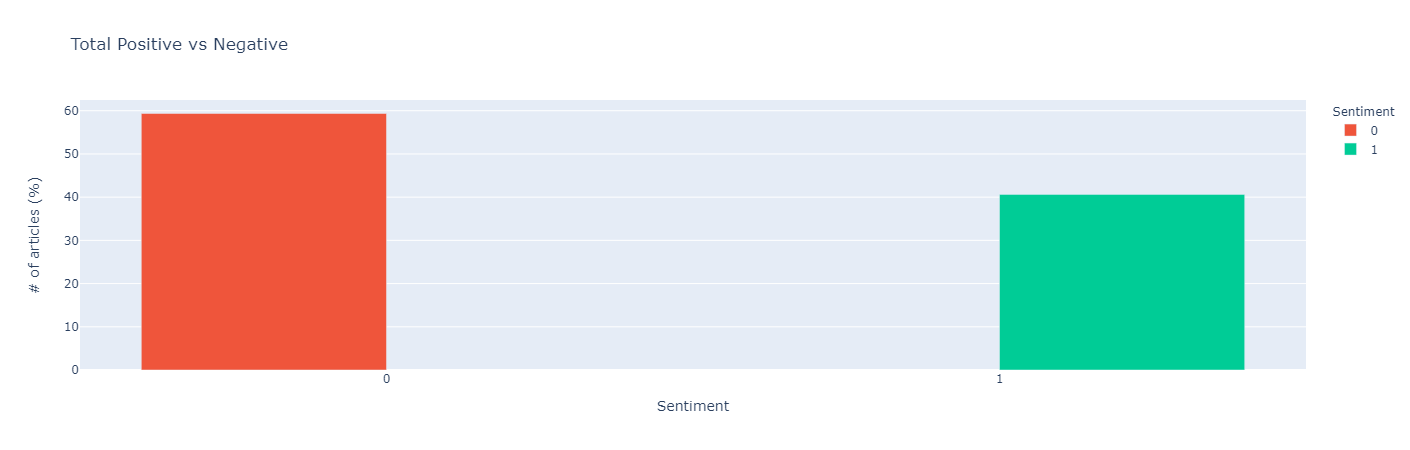

In [46]:
figTotal = px.bar(tot,
                  x="sentiment",
                  y="sentiment %",
                  barmode="group",
                  color="sentiment",
                  color_discrete_map={
                    '0': '#ef553b',
                    '1': '#00cc96'
                    },
                  labels={
                      "sentiment": "Sentiment",
                      "sentiment %": "# of articles (%)",
                      "sentiment": "Sentiment"
                  },
                  title="Total Positive vs Negative"
                  )

figTotal.show()

## Plot all newspaper positive vs negative per total count

In [47]:
grouped= news_concat.groupby(['source','sentiment']).size().reset_index()
grouped['sentiment'] = grouped['sentiment'].astype(str)
grouped = grouped.rename(columns={0:'count'})
grouped = normalize(grouped)
grouped

source sentiment  count  sentiment %
0                        cash         0     29         0.65
1                        cash         1     21         0.47
2     technik smartphone news         0      1         0.02
3                11freunde.de         0      1         0.02
4                  20 minuten         0    461        10.28
..                        ...       ...    ...          ...
392               xboxdynasty         1      1         0.02
393            xboxdynasty.de         1      1         0.02
394                   youtube         0      1         0.02
395       zofingertagblatt.ch         0      1         0.02
396                  öko-test         0      1         0.02

[397 rows x 4 columns]

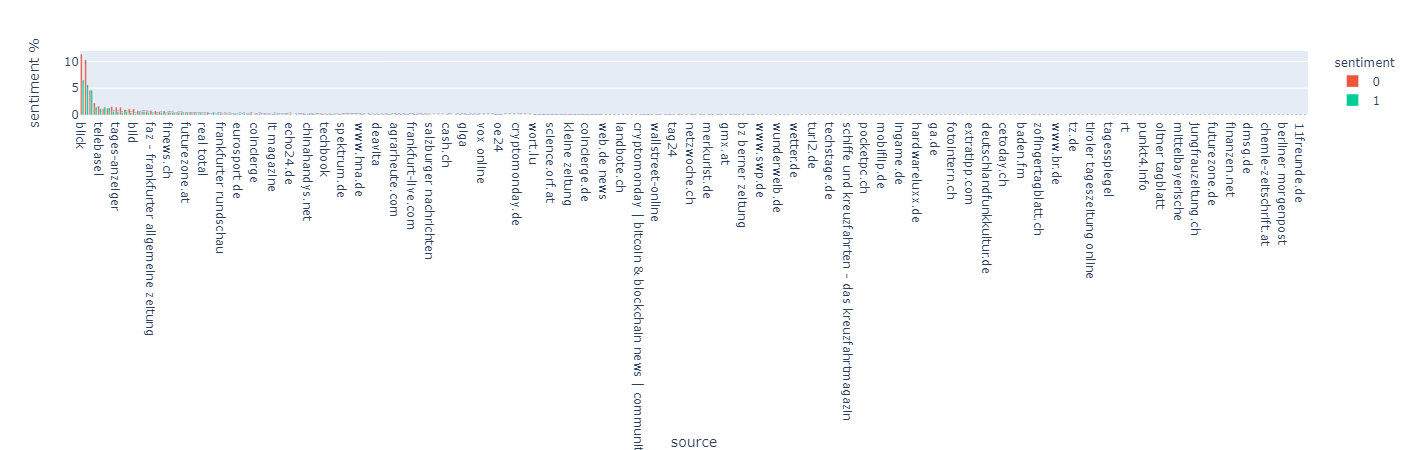

In [48]:
figNews = px.bar(grouped,
                 x="source",
                 y="sentiment %",
                 text = "sentiment %",
                 barmode="group",
                 color="sentiment",
                 color_discrete_map={
                    '0': '#ef553b',
                    '1': '#00cc96'
                    },
                 #facet_col='source', facet_col_wrap=4
                 #facet_row="targetTitle", 
                 #facet_col="category",
                  )
figNews.update_layout(xaxis={'categoryorder':'total descending'})
figNews.show()

## Plot of all newspaper positive vs negative

In [49]:
grouped.source.value_counts()

business insider deutschland     2
coincierge.de                    2
mopo.de                          2
bulgarisches wirtschaftsblatt    2
nzzas.nzz.ch                     2
                                ..
mobiflip.de                      1
gmx.at                           1
np-coburg.de                     1
merkur online                    1
ntower.de                        1
Name: source, Length: 282, dtype: int64

In [50]:
# I take newspapers with more than tot articles, if a newspaper's category is missing I delete it.
clean = grouped.loc[grouped['count'] > 5]

In [51]:
# activate this only if you want a newspaper with both sentiment 
#clean = clean[clean['source'].map(clean['source'].value_counts()) > 1]

In [52]:
clean = clean.groupby(['source']).apply(norm).reset_index(drop=True)

In [53]:
clean

source sentiment  count  sentiment %
0                      cash         0     29        58.00
1                      cash         1     21        42.00
2                20 minuten         0    461        64.57
3                20 minuten         1    253        35.43
4          aargauer zeitung         0     12        66.67
..                      ...       ...    ...          ...
88                   watson         0     52        44.07
89                   watson         1     66        55.93
90  wirtschaftsblatt-bg.com         0      6       100.00
91               www.rtl.de         0      8        57.14
92               www.rtl.de         1      6        42.86

[93 rows x 4 columns]

In [54]:
clean2 = clean.sort_values(by=['count'], ascending=False)
display(clean2.head(35))

source sentiment  count  sentiment %
13                                 blick         0    509        63.62
2                             20 minuten         0    461        64.57
14                                 blick         1    291        36.38
3                             20 minuten         1    253        35.43
80                                   srf         1    207        50.12
79                                   srf         0    206        49.88
65                                nau.ch         0    100        60.61
86                             telebasel         0     73        57.94
48                      heilpraxisnet.de         0     70        70.00
89                                watson         1     66        55.93
84                        tages-anzeiger         0     65        69.15
66                                nau.ch         1     65        39.39
81                              t-online         0     64        75.29
16                            bluewin.ch         1     60        52.17
15                            bluewin.ch         0     55        47.83
87                             telebasel         1     53        42.06
68                  neue zürcher zeitung         0     52        71.23
88                                watson         0     52        44.07
11                                  bild         0     51        80.95
8                  augsburger allgemeine         0     45        60.81
77                         speedweek.com         0     35        57.38
33  faz - frankfurter allgemeine zeitung         0     35        70.00
45                                gmx.ch         0     34        75.56
26                           der spiegel         0     33        67.35
18                              btc-echo         1     30        50.85
49                      heilpraxisnet.de         1     30        30.00
0                                   cash         0     29        58.00
85                        tages-anzeiger         1     29        30.85
9                  augsburger allgemeine         1     29        39.19
17                              btc-echo         0     29        49.15
37                          focus online         0     27        57.45
78                         speedweek.com         1     26        42.62
75          scinexx | das wissensmagazin         0     23        56.10
35                             finews.ch         0     22        50.00
36                             finews.ch         1     22        50.00

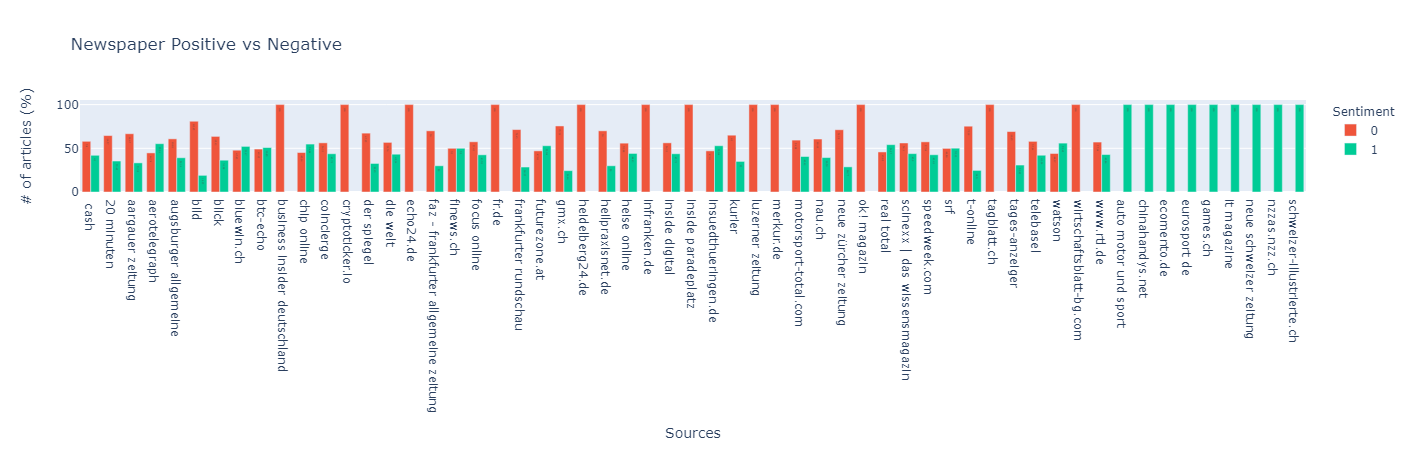

In [55]:
figNews = px.bar(clean,
                 x="source",
                 y="sentiment %",
                 text = "sentiment %",
                 barmode="group",
                 color="sentiment",
                 color_discrete_map={
                    '0': '#ef553b',
                    '1': '#00cc96'
                    },
                 labels={
                      "source": "Sources",
                      "sentiment %": "# of articles (%)",
                      "sentiment": "Sentiment"
                  },
                  title="Newspaper Positive vs Negative"
                  )
                  
figNews.show()

## Plot top 10 positive vs top 10 negative 

In [56]:
# plot newspaper best positive 10
gr10Pos = clean.loc[clean['sentiment'] == '1']
gr10Pos = gr10Pos.loc[gr10Pos['count'] > 15]
gr10Pos = gr10Pos.sort_values(by=['sentiment %'], ascending=False).reset_index(drop=True)

In [57]:
gr10Pos = gr10Pos.head(10)
gr10Pos

source sentiment  count  sentiment %
0       auto motor und sport         1     19       100.00
1  schweizer-illustrierte.ch         1     17       100.00
2                     watson         1     66        55.93
3              aerotelegraph         1     21        55.26
4                chip online         1     17        54.84
5              futurezone.at         1     18        52.94
6                 bluewin.ch         1     60        52.17
7                   btc-echo         1     30        50.85
8                        srf         1    207        50.12
9                  finews.ch         1     22        50.00

In [58]:
# plot newspaper best negative 10
gr10Neg = clean.loc[clean['sentiment'] == '0']
gr10Neg = gr10Neg.loc[gr10Neg['count'] > 15]
gr10Neg = gr10Neg.sort_values(by=['sentiment %'], ascending=False).reset_index(drop=True)

In [59]:
gr10Neg = gr10Neg.head(10)
gr10Neg

source sentiment  count  sentiment %
0                       heidelberg24.de         0     16       100.00
1                           tagblatt.ch         0     19       100.00
2                                  bild         0     51        80.95
3                                gmx.ch         0     34        75.56
4                              t-online         0     64        75.29
5                  neue zürcher zeitung         0     52        71.23
6  faz - frankfurter allgemeine zeitung         0     35        70.00
7                      heilpraxisnet.de         0     70        70.00
8                        tages-anzeiger         0     65        69.15
9                           der spiegel         0     33        67.35

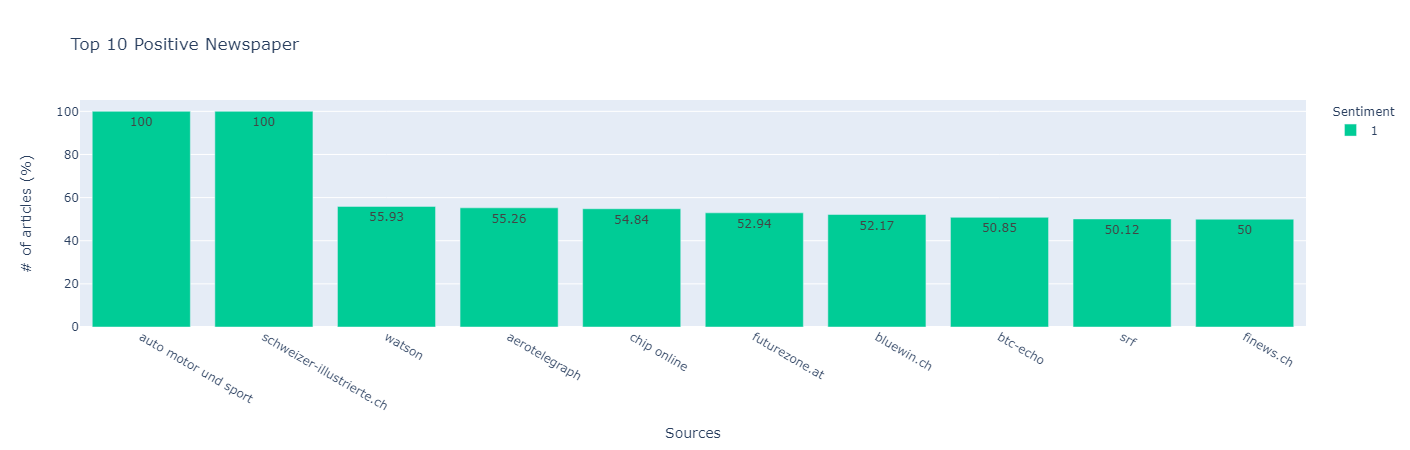

In [60]:
figNews10 = px.bar(gr10Pos,
                   x="source",
                   y="sentiment %",
                   text = "sentiment %", 
                   barmode="group",
                   color="sentiment",
                   color_discrete_map={
                    '0': '#ef553b',
                    '1': '#00cc96'
                    },
                   labels={
                      "source": "Sources",
                      "sentiment %": "# of articles (%)",
                      "sentiment": "Sentiment"
                  },
                  title="Top 10 Positive Newspaper"
                  )

figNews10.show()

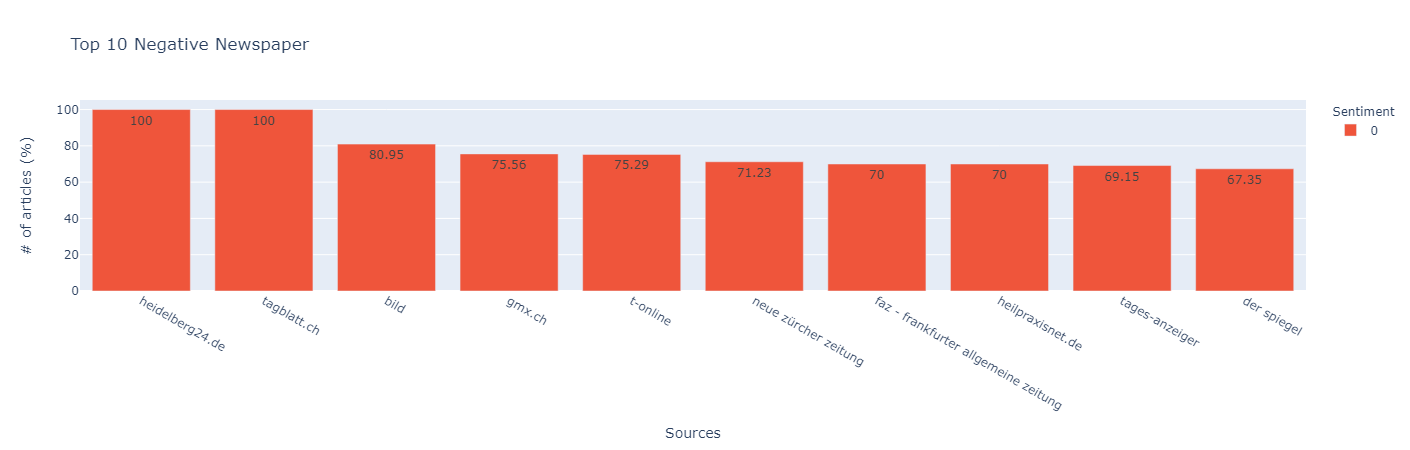

In [61]:
figNews10 = px.bar(gr10Neg,
                   x="source",
                   y="sentiment %",
                   text = "sentiment %", 
                   barmode="group",
                   color="sentiment",
                   color_discrete_map={
                    '0': '#ef553b',
                    '1': '#00cc96'
                    },
                   labels={
                      "source": "Sources",
                      "sentiment %": "# of articles (%)",
                      "sentiment": "Sentiment"
                   },
                   title="Top 10 Negative Newspaper"
                  )

figNews10.show()

## Plot pro category positive vs negative

In [62]:
category = news_concat.groupby(['category','sentiment']).size().reset_index()
category['sentiment'] = category['sentiment'].astype(str)
category = category.rename(columns={0:'count'})
#normalize on the dataset
category = normalize(category)
category

category sentiment  count  sentiment %
0        business         0    185         4.12
1        business         1    190         4.24
2   entertainment         0    279         6.22
3   entertainment         1    227         5.06
4          health         0    360         8.02
5          health         1    180         4.01
6          nation         0    235         5.24
7          nation         1     64         1.43
8         science         0    396         8.83
9         science         1    244         5.44
10          sport         0    330         7.36
11          sport         1    345         7.69
12     technology         0    155         3.46
13     technology         1    138         3.08
14          world         0    723        16.12
15          world         1    435         9.70

In [63]:
# normalize single category
category_clean = category.groupby(['category']).apply(norm).reset_index(drop=True)

In [64]:
category_clean

category sentiment  count  sentiment %
0        business         0    185        49.33
1        business         1    190        50.67
2   entertainment         0    279        55.14
3   entertainment         1    227        44.86
4          health         0    360        66.67
5          health         1    180        33.33
6          nation         0    235        78.60
7          nation         1     64        21.40
8         science         0    396        61.88
9         science         1    244        38.12
10          sport         0    330        48.89
11          sport         1    345        51.11
12     technology         0    155        52.90
13     technology         1    138        47.10
14          world         0    723        62.44
15          world         1    435        37.56

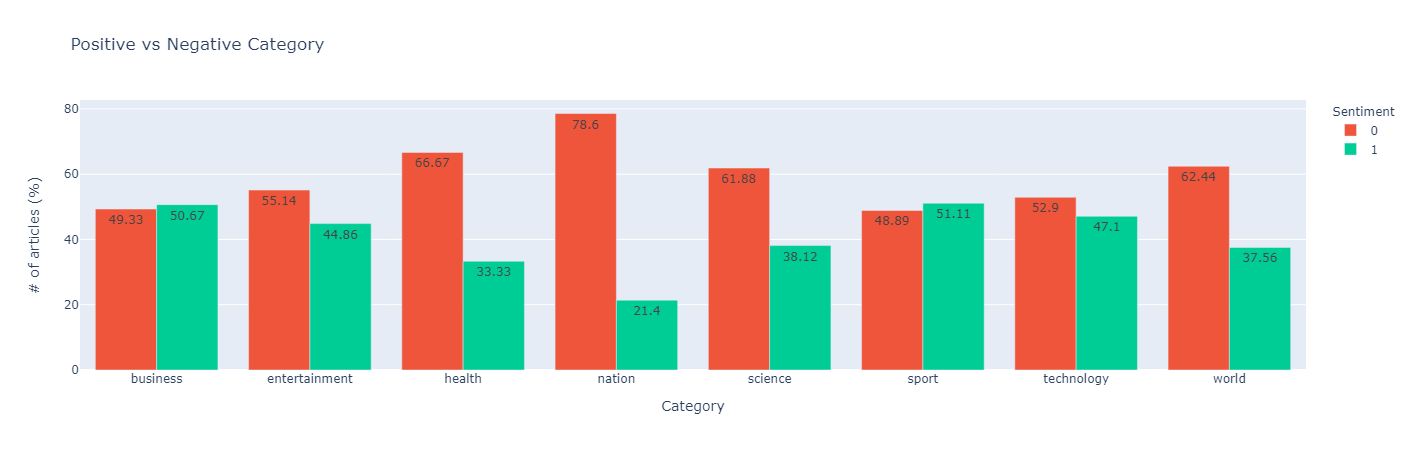

In [65]:
figCat = px.bar(category_clean, 
                x="category", 
                y="sentiment %",
                text = "sentiment %", 
                barmode="group",
                color="sentiment",
                color_discrete_map={
                    '0': '#ef553b',
                    '1': '#00cc96'
                },
                labels={
                      "category": "Category",
                      "sentiment %": "# of articles (%)",
                      "sentiment": "Sentiment"
                  },
                  title="Positive vs Negative Category"
                )

figCat.show()


## Plot pro category of the top 3 newspaper
**I will only consider the three largest newspapers by number of article**

In [66]:
newspaper_source = [
    '20 minuten',
    'blick',
    'srf',
]

In [67]:
news_small = news_concat[news_concat.source.isin(newspaper_source)]

In [68]:
sourceCat = news_small.groupby(['source','category','sentiment']).size().reset_index()
sourceCat['sentiment'] = sourceCat['sentiment'].astype(str)
sourceCat = sourceCat.rename(columns={0:'count'})
# normalized only on category
sourceCat = sourceCat.groupby(['category']).apply(norm).reset_index(drop=True)
sourceCat

source       category sentiment  count  sentiment %
0   20 minuten       business         0     31        20.95
1   20 minuten       business         1     33        22.30
2   20 minuten  entertainment         0     56        22.40
3   20 minuten  entertainment         1     65        26.00
4   20 minuten         health         0      2       100.00
5   20 minuten         nation         0    106        40.30
6   20 minuten         nation         1     21         7.98
7   20 minuten        science         0     10        20.41
8   20 minuten        science         1     10        20.41
9   20 minuten          sport         0     41        10.73
10  20 minuten          sport         1     22         5.76
11  20 minuten     technology         0     13        22.41
12  20 minuten     technology         1     12        20.69
13  20 minuten          world         0    202        26.06
14  20 minuten          world         1     90        11.61
15       blick       business         0     28        18.92
16       blick       business         1     41        27.70
17       blick  entertainment         0     72        28.80
18       blick  entertainment         1     45        18.00
19       blick         nation         0     86        32.70
20       blick         nation         1     27        10.27
21       blick        science         0      4         8.16
22       blick        science         1      8        16.33
23       blick          sport         0    109        28.53
24       blick          sport         1     84        21.99
25       blick     technology         0     12        20.69
26       blick     technology         1      7        12.07
27       blick          world         0    198        25.55
28       blick          world         1     79        10.19
29         srf       business         0     10         6.76
30         srf       business         1      5         3.38
31         srf  entertainment         0      5         2.00
32         srf  entertainment         1      7         2.80
33         srf         nation         0     16         6.08
34         srf         nation         1      7         2.66
35         srf        science         0      9        18.37
36         srf        science         1      8        16.33
37         srf          sport         0     40        10.47
38         srf          sport         1     86        22.51
39         srf     technology         0     10        17.24
40         srf     technology         1      4         6.90
41         srf          world         0    116        14.97
42         srf          world         1     90        11.61

In [69]:
# the right normalization
sourceClean = sourceCat.groupby(['source','category']).apply(norm).reset_index(drop=True)

In [70]:
sourceClean

source       category sentiment  count  sentiment %
0   20 minuten       business         0     31        48.44
1   20 minuten       business         1     33        51.56
2   20 minuten  entertainment         0     56        46.28
3   20 minuten  entertainment         1     65        53.72
4   20 minuten         health         0      2       100.00
5   20 minuten         nation         0    106        83.46
6   20 minuten         nation         1     21        16.54
7   20 minuten        science         0     10        50.00
8   20 minuten        science         1     10        50.00
9   20 minuten          sport         0     41        65.08
10  20 minuten          sport         1     22        34.92
11  20 minuten     technology         0     13        52.00
12  20 minuten     technology         1     12        48.00
13  20 minuten          world         0    202        69.18
14  20 minuten          world         1     90        30.82
15       blick       business         0     28        40.58
16       blick       business         1     41        59.42
17       blick  entertainment         0     72        61.54
18       blick  entertainment         1     45        38.46
19       blick         nation         0     86        76.11
20       blick         nation         1     27        23.89
21       blick        science         0      4        33.33
22       blick        science         1      8        66.67
23       blick          sport         0    109        56.48
24       blick          sport         1     84        43.52
25       blick     technology         0     12        63.16
26       blick     technology         1      7        36.84
27       blick          world         0    198        71.48
28       blick          world         1     79        28.52
29         srf       business         0     10        66.67
30         srf       business         1      5        33.33
31         srf  entertainment         0      5        41.67
32         srf  entertainment         1      7        58.33
33         srf         nation         0     16        69.57
34         srf         nation         1      7        30.43
35         srf        science         0      9        52.94
36         srf        science         1      8        47.06
37         srf          sport         0     40        31.75
38         srf          sport         1     86        68.25
39         srf     technology         0     10        71.43
40         srf     technology         1      4        28.57
41         srf          world         0    116        56.31
42         srf          world         1     90        43.69

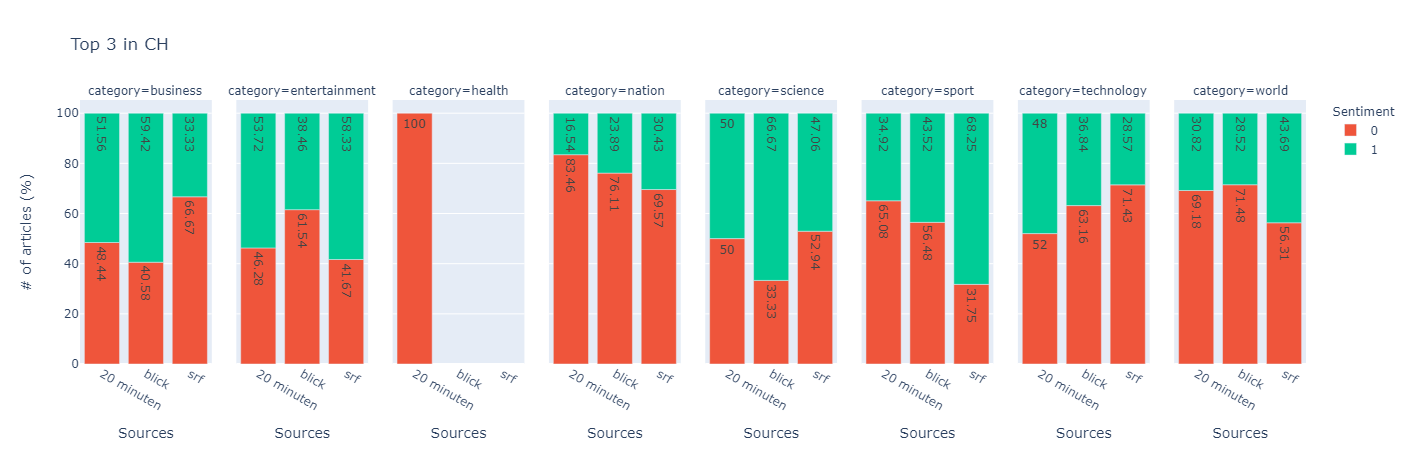

In [71]:
figCat = px.bar(sourceClean,
                x="source",
                y="sentiment %",
                text = "sentiment %", 
                #barmode="group",
                color="sentiment",
                color_discrete_map={
                    '0': '#ef553b',
                    '1': '#00cc96'
                },
                #facet_row='sentiment', 
                facet_col="category",
                #facet_col_wrap=4
                #facet_row="targetTitle", 
                #facet_col="category",
                labels={
                    "source": "Sources",
                    "sentiment %": "# of articles (%)",
                    "sentiment": "Sentiment"
                  },
                title="Top 3 in CH"
                )

figCat.show()

For visualisation I create a minus value for "negative" values

In [72]:
sourceClean2 = sourceClean.copy()

In [73]:
sourceClean2['sentiment %'] = sourceClean2['sentiment %'] * (2 * sourceClean2['sentiment'].astype(int) - 1)

In [74]:
sourceClean2

source       category sentiment  count  sentiment %
0   20 minuten       business         0     31       -48.44
1   20 minuten       business         1     33        51.56
2   20 minuten  entertainment         0     56       -46.28
3   20 minuten  entertainment         1     65        53.72
4   20 minuten         health         0      2      -100.00
5   20 minuten         nation         0    106       -83.46
6   20 minuten         nation         1     21        16.54
7   20 minuten        science         0     10       -50.00
8   20 minuten        science         1     10        50.00
9   20 minuten          sport         0     41       -65.08
10  20 minuten          sport         1     22        34.92
11  20 minuten     technology         0     13       -52.00
12  20 minuten     technology         1     12        48.00
13  20 minuten          world         0    202       -69.18
14  20 minuten          world         1     90        30.82
15       blick       business         0     28       -40.58
16       blick       business         1     41        59.42
17       blick  entertainment         0     72       -61.54
18       blick  entertainment         1     45        38.46
19       blick         nation         0     86       -76.11
20       blick         nation         1     27        23.89
21       blick        science         0      4       -33.33
22       blick        science         1      8        66.67
23       blick          sport         0    109       -56.48
24       blick          sport         1     84        43.52
25       blick     technology         0     12       -63.16
26       blick     technology         1      7        36.84
27       blick          world         0    198       -71.48
28       blick          world         1     79        28.52
29         srf       business         0     10       -66.67
30         srf       business         1      5        33.33
31         srf  entertainment         0      5       -41.67
32         srf  entertainment         1      7        58.33
33         srf         nation         0     16       -69.57
34         srf         nation         1      7        30.43
35         srf        science         0      9       -52.94
36         srf        science         1      8        47.06
37         srf          sport         0     40       -31.75
38         srf          sport         1     86        68.25
39         srf     technology         0     10       -71.43
40         srf     technology         1      4        28.57
41         srf          world         0    116       -56.31
42         srf          world         1     90        43.69

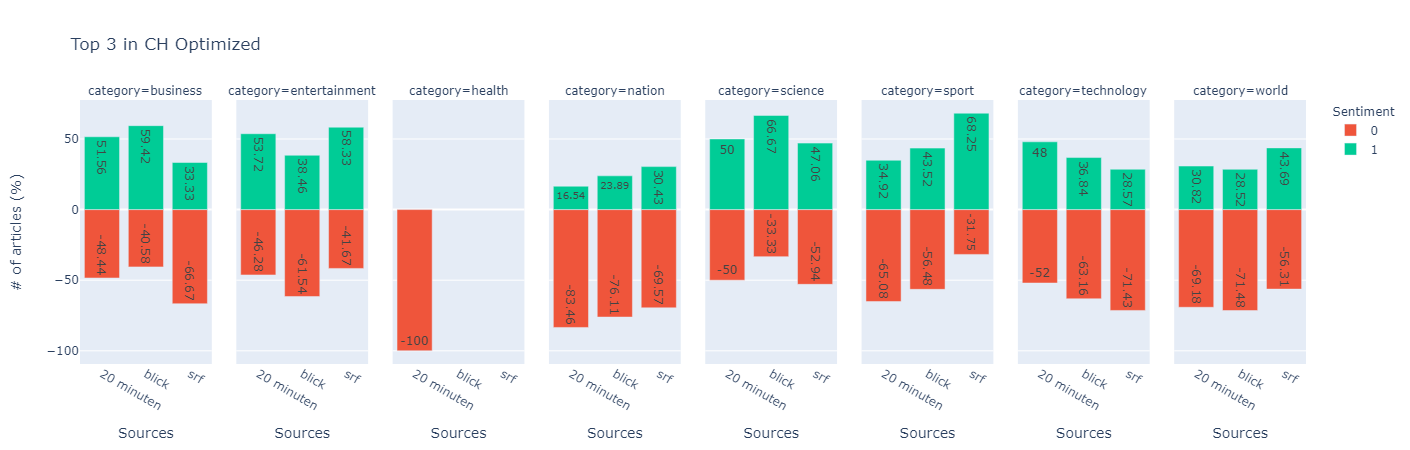

In [75]:
figCat = px.bar(sourceClean2,
                x="source",
                y="sentiment %",
                text = "sentiment %", 
                #barmode="group",
                color="sentiment",
                color_discrete_map={
                    '0': '#ef553b',
                    '1': '#00cc96'
                },
                #facet_row='sentiment', 
                facet_col="category",
                #facet_col_wrap=4
                #facet_row="targetTitle", 
                #facet_col="category",
                labels={
                    "source": "Sources",
                    "sentiment %": "# of articles (%)",
                    "sentiment": "Sentiment"
                  },
                title="Top 3 in CH Optimized"
                )

figCat.show()

## Plot spider category of a single newspaper


In [76]:
sourceCat = news_concat.groupby(['source','category','sentiment']).size().reset_index()
sourceCat['sentiment'] = sourceCat['sentiment'].astype(str)
sourceCat = sourceCat.rename(columns={0:'count'})
sourceCat = sourceCat.groupby(['category']).apply(norm).reset_index(drop=True)
sourceCat

source    category sentiment  count  sentiment %
0                        cash     science         0      1         0.16
1                        cash  technology         0     28         9.56
2                        cash  technology         1     21         7.17
3     technik smartphone news      health         0      1         0.19
4                11freunde.de       sport         0      1         0.15
..                        ...         ...       ...    ...          ...
607               xboxdynasty  technology         1      1         0.34
608            xboxdynasty.de       world         1      1         0.09
609                   youtube     science         0      1         0.16
610       zofingertagblatt.ch      health         0      1         0.19
611                  öko-test      health         0      1         0.19

[612 rows x 5 columns]

## Def for plotting SPIDER

In [77]:
def plot_spider(df_name):
    d_name = str(df_name)
    df_name = sourceCat.loc[sourceCat['source'] == d_name ]
    df_name = df_name.groupby(['category']).apply(norm).reset_index(drop=True)
    df_name_pos = df_name.loc[df_name['sentiment'] == '1']
    df_name_neg = df_name.loc[df_name['sentiment'] == '0']
    
    label_neg = d_name + " NEG %"
    label_pos = d_name +" POS %"
    
    fig = go.Figure()
    fig.add_trace(go.Scatterpolar(
            r=df_name_neg['sentiment %'],
            theta=df_name_neg['category'], 
            fill='toself',
            mode = 'markers',
            name= label_neg,
            line_color = '#ef553b'
    ))
    fig.add_trace(go.Scatterpolar(
            r=df_name_pos['sentiment %'],
            theta=df_name_pos['category'], 
            fill='toself',
            mode = 'markers',
            name= label_pos ,
            line_color = '#00cc96'
        ))


    fig.update_layout(
        title = 'Spider Comparison: '+ d_name,
        showlegend = True
    )

    fig.show()

### Plot spider

In [78]:
list_newspaper = [
    '20 minuten',
    'blick',
    'bluewin.ch',
    'finews.ch',
    'nau.ch',
    'neue zürcher zeitung',
    'srf',
    'telebasel',
    'tages-anzeiger',
    'watson'
]

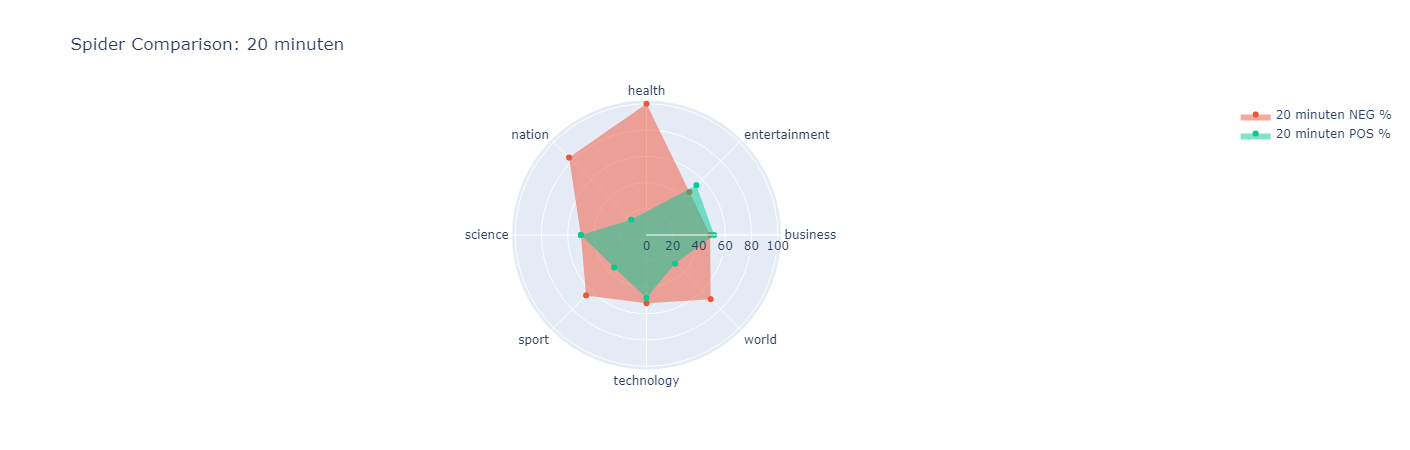

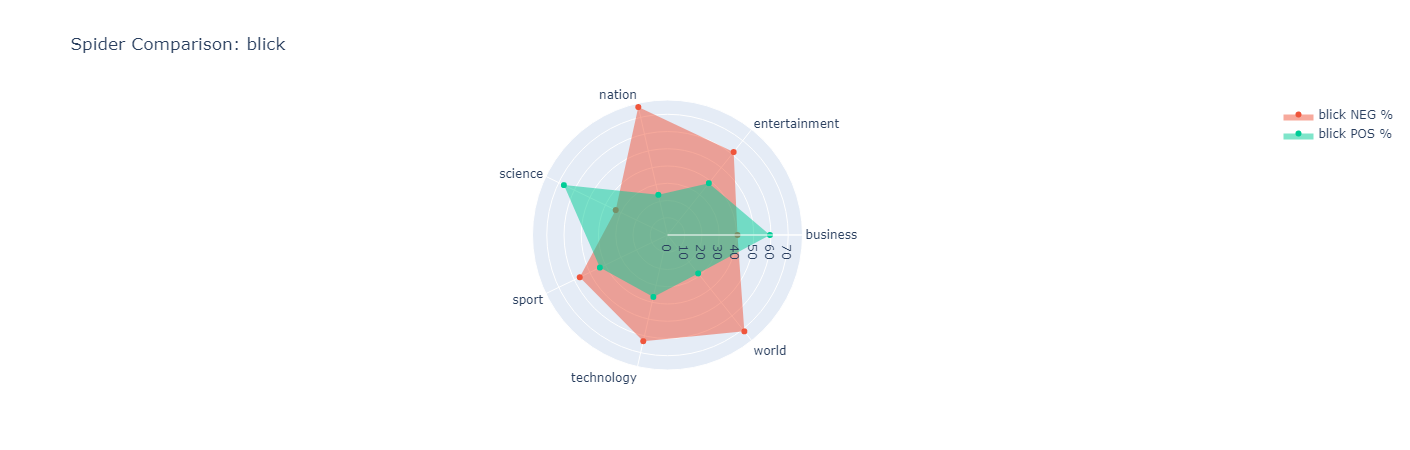

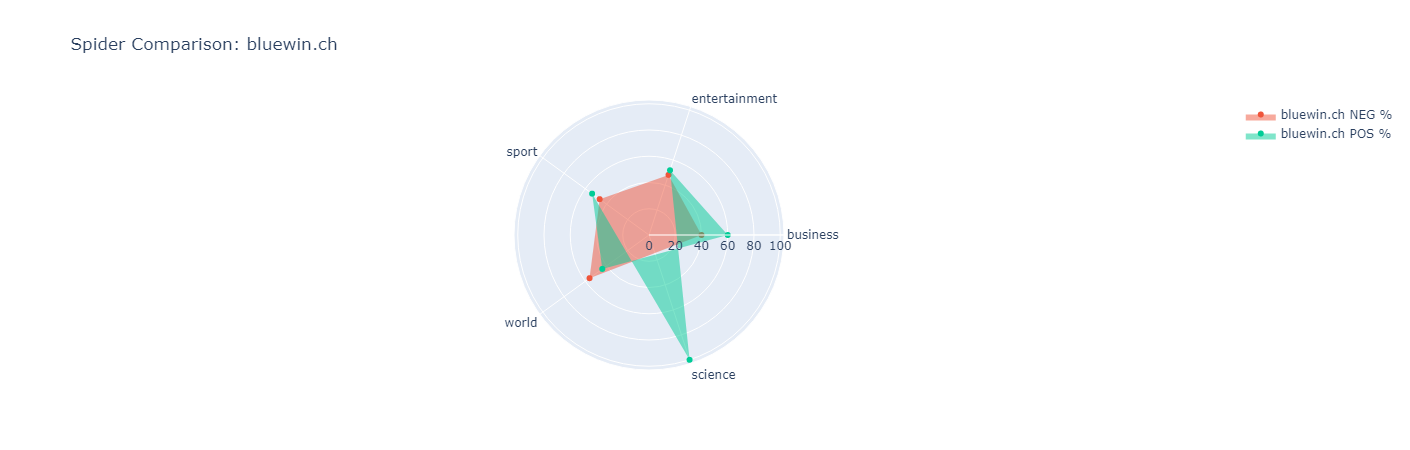

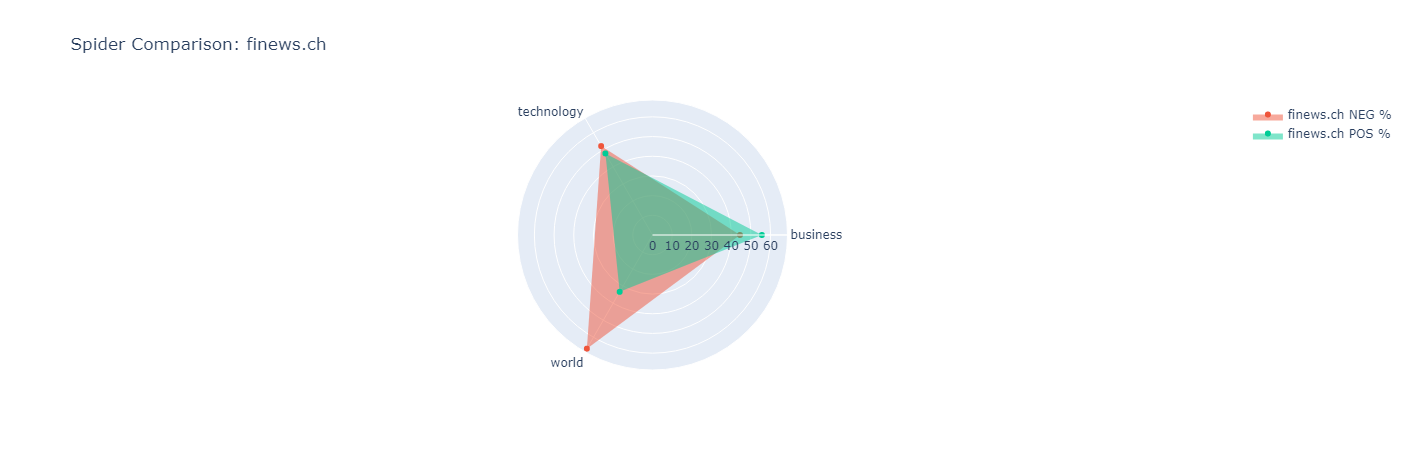

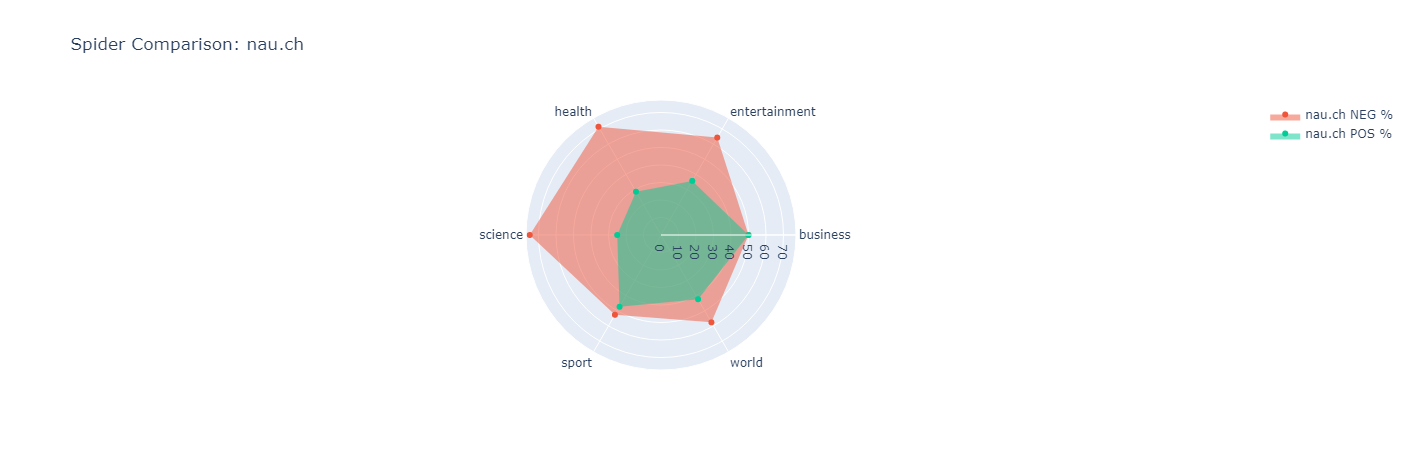

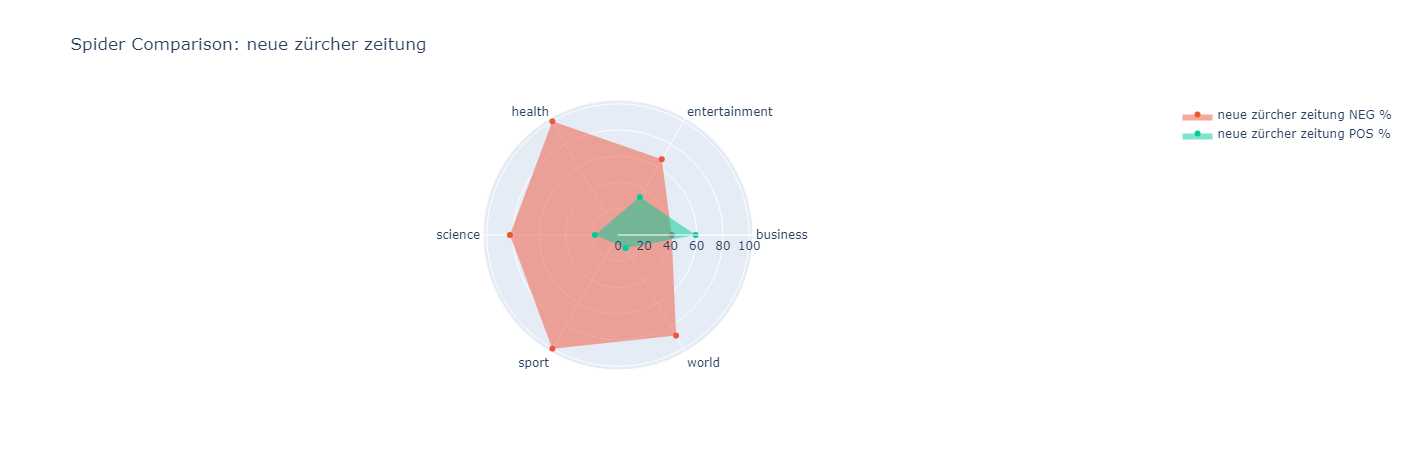

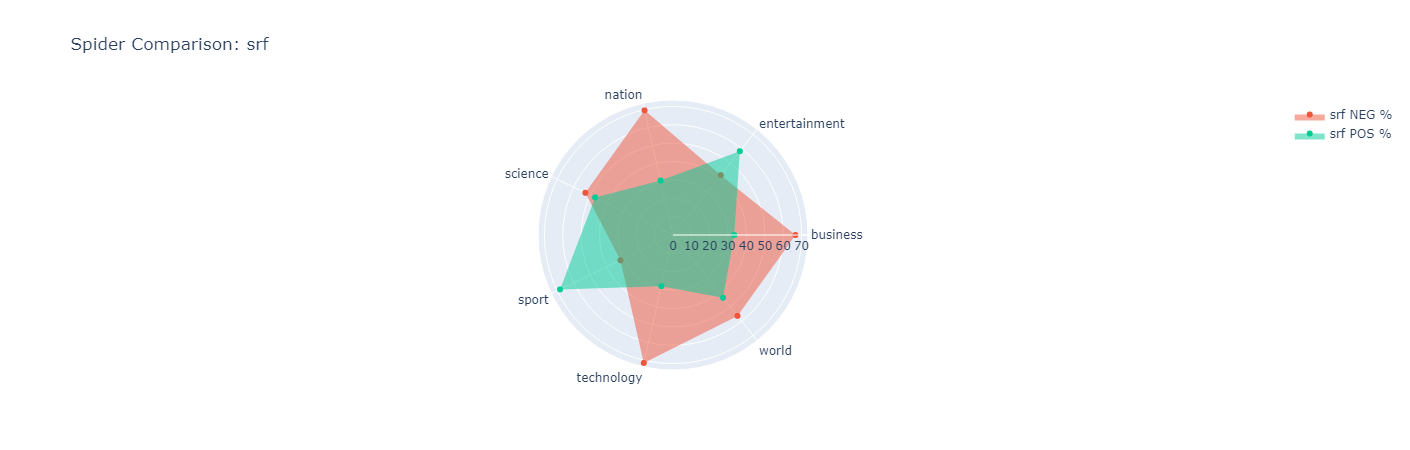

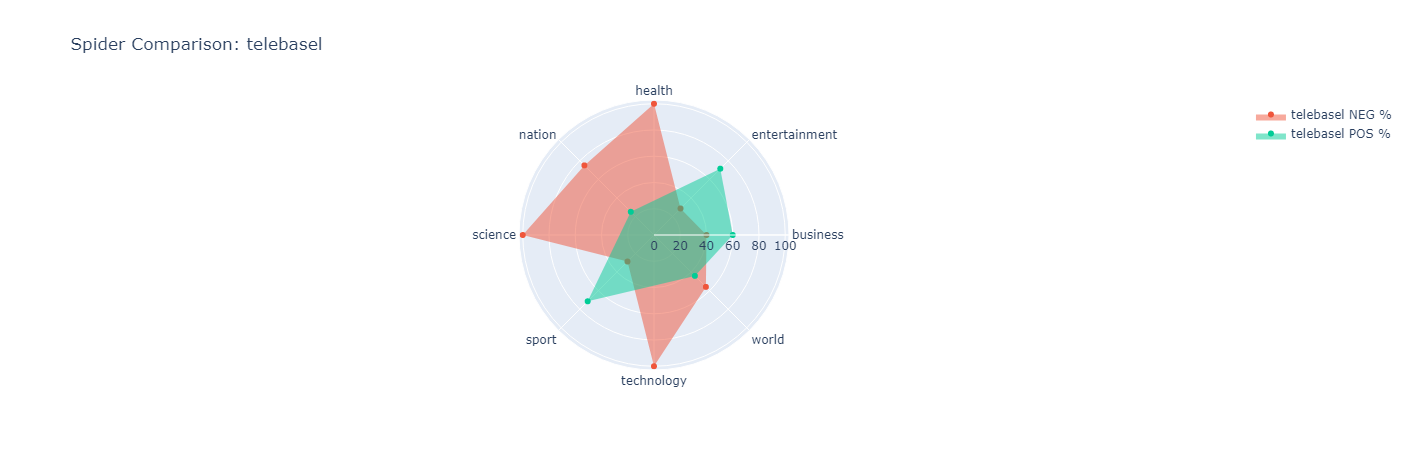

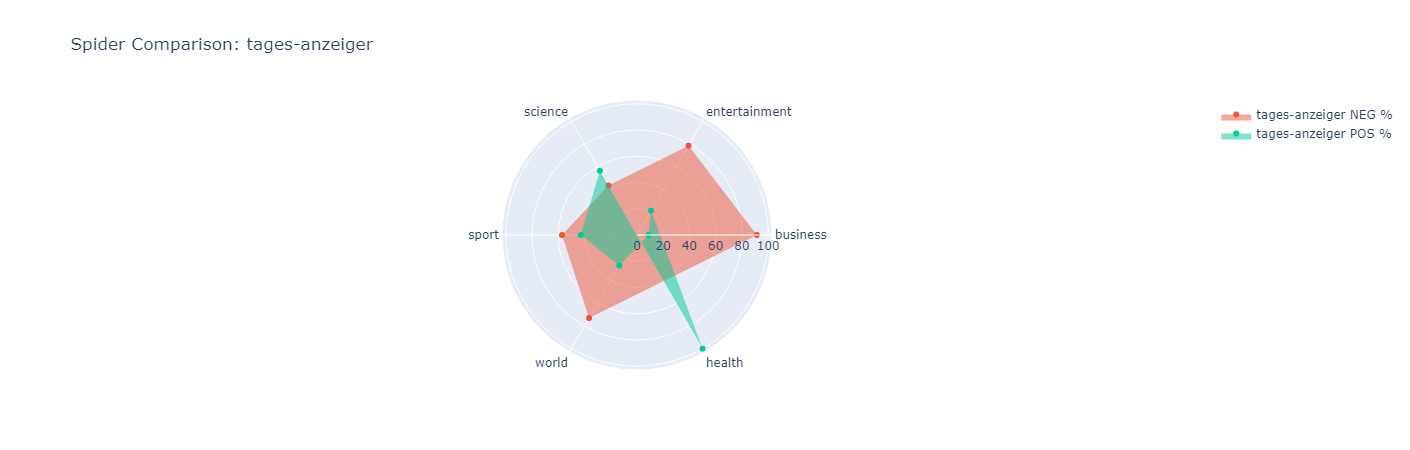

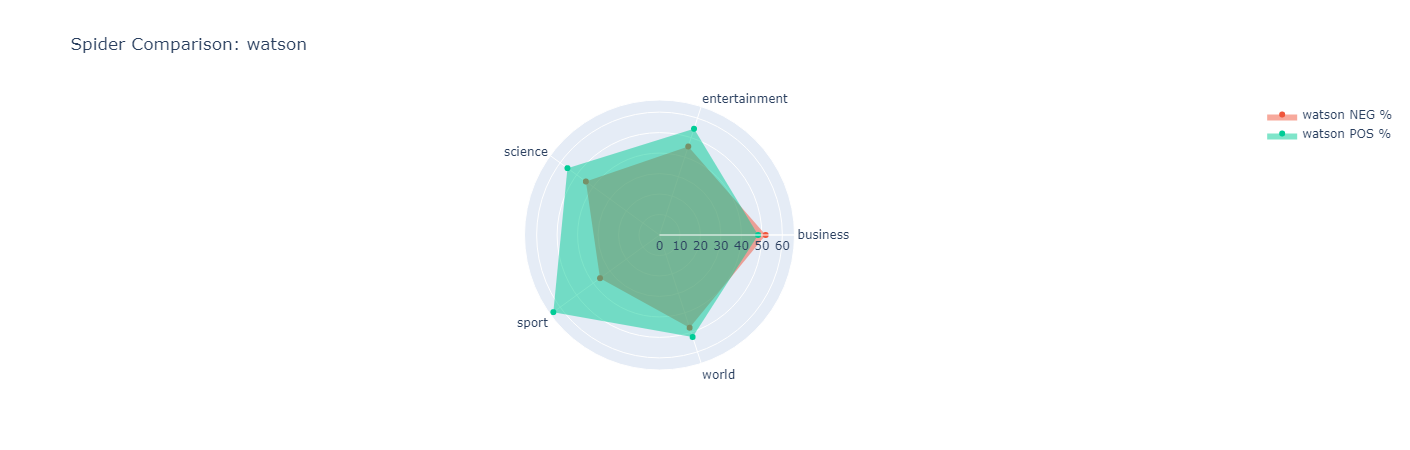

In [79]:
for x in list_newspaper:
    plot_spider(x)

# Plot in Time

In [80]:
def create_df_time(df_filter, subject):
    df = df_filter.groupby(['date_parsed',subject,'sentiment']).size().reset_index()
    df['sentiment'] = df['sentiment'].astype(str)
    df = df.rename(columns={0:'count'})
    df = normalize(df)
    
    df_pos= df.loc[df['sentiment'] == '1']
    df_neg = df.loc[df['sentiment'] == '0']
    # how much influence a newspaper had(pos neg) in % per day 
    df_pos = df_pos.groupby(['date_parsed']).apply(norm).reset_index(drop=True)
    df_neg = df_neg.groupby(['date_parsed']).apply(norm).reset_index(drop=True)
    df_pos[subject] = df_pos[subject].astype(str) + '_pos' 
    df_neg[subject] = df_neg[subject].astype(str) + '_neg' 
    df_concat = pd.concat([df_pos,df_neg],ignore_index=True)
    
    # pivot table
    test = df_concat.pivot(index=subject,columns='date_parsed', values='sentiment %')
    test = test.fillna(0)
    test = test.reset_index()
    return test

## Plot newspaper in time

In [81]:
newspaper_source = [
    '20 minuten',
    'blick',
    #'bluewin.ch',
    #'finews.ch',
    #'nau.ch',
    #'neue zürcher zeitung',
    'srf',
    #'telebasel',
    #'tages-anzeiger',
    #'watson'
]

In [82]:
news_small = news_concat[news_concat.source.isin(newspaper_source)]

In [83]:
# Filter data between two dates
filtered_df = news_small.loc[(news_small['date_parsed'] >= '2021-05-01') & (news_small['date_parsed']<= '2021-05-31')]

In [84]:
filtered_df

source  \
0     20 minuten   
1          blick   
2     20 minuten   
10         blick   
12           srf   
...          ...   
4475       blick   
4476       blick   
4477       blick   
4478         srf   
4479         srf   

                                                                                                                                                                                                                                                  content  \
0                    Verletzung im Schädelinneren : Frau lief nach Corona-Test Hirnwasser aus dem Kopf. In Osnabrück ist eine Frau beim Corona-Schnelltest im Inneren ihres Schädels verletzt worden. Danach lief ihr wochenlang Hirnwasser aus dem Kopf.   
1                                                                                         USA: Freizeitpark wieder auf. 13 Monate lang war Disneyland wegen der Corona-Pandemie stillgelegt, nun hat der beliebte Freizeitpark in Kalifornien wieder auf.   
2                   Verdacht auf Menschenschmuggel : US-Polizei findet 91 Menschen ohne Papiere in Wohnhaus. Auf Hinweis einer Entführung finden Polizeibeamte in Houston, im US-Bundesstaat Texas, 91 Frauen und Männer ohne gültige Aufenthaltspapiere.   
10    Ironman: Ryf läuft mit Streckenrekord zu Sieg in St. George. In St. George feiert Daniela Ryf ihren zweiten Saisonsieg in einem 70.3-Ironman. Ein gutes Omen für die Mitteldistanz-WM, die im September auf der gleichen Strecke durchgeführt wird.   
12                                                                    32. Runde der Super League - Luzern verschafft sich weiter Luft im Abstiegskampf. Der FC Luzern gewinnt bei Vaduz 2:1 und baut den Vorsprung auf den Barrageplatz auf 9 Punkte aus.   
...                                                                                                                                                                                                                                                   ...   
4475                                             Premier League: Liverpool gewinnt Nachholspiel gegen ManUtd. Liverpool holt sich im Nachholspiel gegen Manchester United einen wichtigen Sieg. Vor der Partie kommts allerdings erneut zu Fan-Protesten.   
4476       Nach Fotos von Kobe Bryants Absturz - zwei Feuerwehrmänner gefeuert. Sie waren bei Kobe Bryants (†41) Helikopterabsturz im Einsatz: Zwei Feuerwehrleute in Los Angeles verlieren ihren Job, weil sie Fotos von der Unfallstelle gemacht haben.   
4477            Radsport: Gino Mäder gewinnt Bergankunft am Giro. Drei Kilometer vor dem Ziel lässt der Schweizer Gino Mäder (24, Bahrain Victorious) seine letzten beiden Begleiter stehen und gewinnt die 6. Etappe des Giro d'Italia in Ascoli Piceno.   
4478                                       Schweizer Sieg beim Giro - Paukenschlag beim Giro: Gino Mäder siegt auf der 6. Etappe. Der Fahrer vom Team Bahrain Victorious siegt in Ascoli Pieno. Zuvor hatte er sich von einer Ausreissergruppe abgesetzt.   
4479                                                       Final im DFB-Pokal - Gegen Leipzig: Holen sich Bürki und der BVB den "Pott"?. Dortmund will mit einem Pokalsieg eine durchwachsene Saison «retten» – Leipzig den ersten Titel überhaupt holen.   

     category sentiment date_parsed  
0       world         0  2021-05-01  
1       world         1  2021-05-01  
2       world         0  2021-05-01  
10      world         1  2021-05-01  
12      world         1  2021-05-01  
...       ...       ...         ...  
4475    sport         1  2021-05-13  
4476    sport         0  2021-05-13  
4477    sport         1  2021-05-13  
4478    sport         1  2021-05-13  
4479    sport         1  2021-05-13  

[1895 rows x 5 columns]

In [85]:
source_time = create_df_time(filtered_df, 'source')

In [86]:
source_time

date_parsed          source  2021-05-01  2021-05-02  2021-05-03  2021-05-04  \
0            20 minuten_neg       34.38       57.58       39.39        42.5   
1            20 minuten_pos        9.09       35.29       43.75        35.0   
2                 blick_neg       56.25       36.36       42.42        42.5   
3                 blick_pos       63.64       47.06       37.50        40.0   
4                   srf_neg        9.38        6.06       18.18        15.0   
5                   srf_pos       27.27       17.65       18.75        25.0   

date_parsed  2021-05-05  2021-05-06  2021-05-07  2021-05-08  2021-05-09  ...  \
0                 45.00       38.64       29.03       24.24       41.18  ...   
1                 41.18       39.29       47.83       33.33       44.44  ...   
2                 40.00       50.00       61.29       51.52       35.29  ...   
3                 38.24       35.71       30.43       33.33       22.22  ...   
4                 15.00       11.36        9.68       24.24       23.53  ...   
5                 20.59       25.00       21.74       33.33       33.33  ...   

date_parsed  2021-05-22  2021-05-23  2021-05-24  2021-05-25  2021-05-26  \
0                 29.41       20.69       31.25       41.07       30.23   
1                 23.81       36.84       11.76       32.35       44.44   
2                 52.94       37.93       59.38       35.71       55.81   
3                 23.81       36.84       64.71       44.12       33.33   
4                 17.65       41.38        9.38       23.21       13.95   
5                 52.38       26.32       23.53       23.53       22.22   

date_parsed  2021-05-27  2021-05-28  2021-05-29  2021-05-30  2021-05-31  
0                 50.94       36.11       22.58       53.85       56.25  
1                 33.33       28.00       38.10       37.50       23.53  
2                 33.96       44.44       54.84       30.77       31.25  
3                 36.67       32.00       47.62       37.50       23.53  
4                 15.09       19.44       22.58       15.38       12.50  
5                 30.00       40.00       14.29       25.00       52.94  

[6 rows x 32 columns]

In [92]:
HTML('''<div class="flourish-embed flourish-chart" data-src="visualisation/6126744"><script src="https://public.flourish.studio/resources/embed.js"></script></div>''')

## Plot category in time


In [87]:
big_filtered_df = news_concat.loc[(news_concat['date_parsed'] >= '2021-05-01') & (news_concat['date_parsed']<= '2021-05-31')]

In [88]:
cat_time = create_df_time(big_filtered_df, 'category')

In [89]:
cat_time

date_parsed           category  2021-05-01  2021-05-02  2021-05-03  \
0                 business_neg        3.70        4.55       11.84   
1                 business_pos        4.35        4.76        8.00   
2            entertainment_neg        9.26       10.61        3.95   
3            entertainment_pos        4.35        7.14        8.00   
4                   health_neg        9.26        9.09       22.37   
5                   health_pos        6.52        7.14       12.00   
6                   nation_neg       12.96        9.09        9.21   
7                   nation_pos        4.35        0.00        6.00   
8                  science_neg       14.81       15.15       14.47   
9                  science_pos       19.57       14.29       24.00   
10                   sport_neg       12.96       22.73        7.89   
11                   sport_pos       19.57       30.95        8.00   
12              technology_neg        3.70        6.06        5.26   
13              technology_pos       15.22        9.52       10.00   
14                   world_neg       33.33       22.73       25.00   
15                   world_pos       26.09       26.19       24.00   

date_parsed  2021-05-04  2021-05-05  2021-05-06  2021-05-07  2021-05-08  \
0                  8.14       10.11        8.33        4.23        0.00   
1                 16.07       21.31       14.29        3.45        6.12   
2                 11.63       10.11        6.25       11.27        5.56   
3                 10.71       21.31       17.46       10.34        2.04   
4                 15.12       13.48       17.71       15.49       26.39   
5                 10.71        3.28       15.87        8.62       24.49   
6                 10.47        7.87        6.25        8.45        8.33   
7                  0.00        3.28        4.76       10.34        4.08   
8                 13.95       16.85       17.71       18.31        5.56   
9                 17.86       13.11       11.11       20.69       16.33   
10                12.79       12.36       15.62       12.68       16.67   
11                16.07       14.75       20.63       10.34       16.33   
12                 4.65        6.74        3.12        7.04        6.94   
13                 7.14        4.92        1.59        8.62        4.08   
14                23.26       22.47       25.00       22.54       30.56   
15                21.43       18.03       14.29       27.59       26.53   

date_parsed  2021-05-09  ...  2021-05-22  2021-05-23  2021-05-24  2021-05-25  \
0                  4.11  ...        5.71        0.00        2.99        5.22   
1                  2.50  ...        0.00        7.69        2.04       19.77   
2                  8.22  ...        8.57        7.14       10.45       12.17   
3                  5.00  ...       10.87       20.51       22.45       11.63   
4                 20.55  ...       11.43       11.43        5.97       12.17   
5                 17.50  ...        8.70        5.13        6.12        6.98   
6                 12.33  ...       11.43        4.29       11.94        7.83   
7                  2.50  ...        4.35        0.00        4.08        0.00   
8                 12.33  ...       12.86       18.57       13.43       13.04   
9                 10.00  ...       19.57        2.56       12.24        8.14   
10                15.07  ...       12.86        5.71       22.39        8.70   
11                22.50  ...       28.26       38.46       24.49       18.60   
12                 2.74  ...       10.00       11.43        2.99        6.09   
13                10.00  ...        4.35        5.13       14.29       10.47   
14                24.66  ...       27.14       41.43       29.85       34.78   
15                30.00  ...       23.91       20.51       14.29       24.42   

date_parsed  2021-05-26  2021-05-27  2021-05-28  2021-05-29  2021-05-30  \
0                 11.70        6.03        6.02        8.11        1.79   
1                  9.5

In [93]:
HTML('''<div class="flourish-embed flourish-chart" data-src="visualisation/6167385"><script src="https://public.flourish.studio/resources/embed.js"></script></div>''')

## Export

In [90]:
cat_time.to_csv('cat_time.csv')
source_time.to_csv('source_time.csv')